In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#!pip install EXCAT-Sync
#!pip install requests_toolbelt

## Import packages

In [78]:
import numpy as np
from pathlib import Path
import openslide
from tqdm import tqdm
import cv2
import pandas as pd
import math
import matplotlib.pyplot as plt

## Download the data from the EXACT Server

In [3]:
from exact_sync.v1.api.annotations_api import AnnotationsApi
from exact_sync.v1.api.images_api import ImagesApi
from exact_sync.v1.api.image_sets_api import ImageSetsApi
from exact_sync.v1.api.annotation_types_api import AnnotationTypesApi
from exact_sync.v1.api.products_api import ProductsApi
from exact_sync.v1.api.teams_api import TeamsApi

from exact_sync.v1.models import ImageSet, Team, Product, AnnotationType, Annotation, AnnotationMediaFile
from exact_sync.v1.rest import ApiException
from exact_sync.v1.configuration import Configuration
from exact_sync.v1.api_client import ApiClient

In [13]:
configuration = Configuration()
configuration.username = 'exact'
configuration.password = 'exact'
configuration.host = "http://127.0.0.1:8000"

client = ApiClient(configuration)

image_sets_api = ImageSetsApi(client)
annotations_api = AnnotationsApi(client)
annotation_types_api = AnnotationTypesApi(client)
images_api = ImagesApi(client)
product_api = ProductsApi(client)

In [14]:
image_sets = image_sets_api.list_image_sets(id=169)
image_sets

{'count': 1,
 'next': None,
 'previous': None,
 'results': [{'creator': 1,
              'description': '',
              'id': 169,
              'images': [1461,
                         1462,
                         1463,
                         1464,
                         1465,
                         1466,
                         1467,
                         1468,
                         1469,
                         1470,
                         1471,
                         1472,
                         1473,
                         1474,
                         1475,
                         1476,
                         1477,
                         1478,
                         1479,
                         1480],
              'location': None,
              'main_annotation_type': None,
              'name': 'Asthma_MICCAI',
              'path': 'exact_166_169',
              'product_set': [138],
              'set_tags': [],
              'team': 166}

In [20]:
images = {}
annotation_types = {}

total_annotations = {}
for image_set in [169]:
    total_annotations[image_set] = []
    for image in images_api.list_images(pagination=False, image_set=image_set).results:
        images[image.name] = image
    for product in [138]:
        for anno_type in annotation_types_api.list_annotation_types(product=product).results:
            annotation_types[anno_type.id] = anno_type

In [55]:
help(images_api.download_image)

Help on method download_image in module exact_sync.v1.api.images_api:

download_image(id, target_path:pathlib.Path, **kwargs) method of exact_sync.v1.api.images_api.ImagesApi instance



In [90]:
annotations = []

for image in images.values():
    
    image_path = Path(image.name)
    
    if image_path.is_file() == False:
        images_api.download_image(id=image.id, target_path=image_path, original_image=True)
    
    for annotation in annotations_api.list_annotations(image=image.id, pagination=False).results:
        annotation.annotation_type = annotation_types[annotation.annotation_type]
        
        annotations.append([image.id, image.name, annotation.vector, annotation.annotation_type.name])
    
annotations = pd.DataFrame(annotations, columns=["id", "file", "vector", "label"])
annotations.head()

id                                  file  \
0  1461  BAL 1 Spray 2_12354_6185_340_265.png   
1  1461  BAL 1 Spray 2_12354_6185_340_265.png   
2  1461  BAL 1 Spray 2_12354_6185_340_265.png   
3  1461  BAL 1 Spray 2_12354_6185_340_265.png   
4  1461  BAL 1 Spray 2_12354_6185_340_265.png   

                                         vector        label  
0    {'x1': 252, 'x2': 308, 'y1': 12, 'y2': 64}  Makrophagen  
1      {'x1': 0, 'x2': 6, 'y1': 158, 'y2': 206}  Lymohozyten  
2    {'x1': 60, 'x2': 98, 'y1': 245, 'y2': 266}  Lymohozyten  
3   {'x1': 96, 'x2': 130, 'y1': 245, 'y2': 266}  Lymohozyten  
4  {'x1': 125, 'x2': 154, 'y1': 239, 'y2': 266}  Lymohozyten

# Create Annoation Map

In [103]:
context_offset = 0.15
patch_width = 100
patch_height = 100
result_image_names = {}

result_annotations = []
for label in annotations["label"].unique():
    
    labelDF = annotations[annotations["label"] == label]
        
    annotation_count = len(labelDF)
    
    x_images = math.ceil(math.sqrt(annotation_count))
    y_images = math.ceil(math.sqrt(annotation_count))
    
    x_total_size = int(x_images * patch_width)
    y_total_size = int(y_images * patch_height)
    
    result_image = np.zeros(shape=(y_total_size, x_total_size, 3), dtype=np.uint8)
    
    ids = list(labelDF.index)
    name = '{0}_map.tiff'.format(label)
    result_image_names[name] = annotation_count
    
    x_total_max = 0
    y_total_max = 0
    
    for x_row in range(x_images):
        x_start = x_total_max
        y_max = 0
    
        for y_row in range(y_images):
            if len(ids) == 0:
                break
                
            id = ids.pop()
            anno = annotations.iloc[id]
            
            source_image = cv2.imread(anno.file)
            
            x_ori = int(anno.vector["x1"])
            y_ori = int(anno.vector["y1"])
            w_ori = int(anno.vector["x2"] - x_ori)
            h_ori = int(anno.vector["y2"] - y_ori)
            
            patch = source_image[y_ori:y_ori+h_ori,x_ori:x_ori+w_ori]
            if patch.shape[0] <= 1 or patch.shape[1] <= 1:
                continue
            
            patch = cv2.resize(patch, (patch_width, patch_height))
            
            x_min = x_start
            x_max = x_min + patch.shape[1]
            x_total_max = x_max if x_max > x_total_max else x_total_max

            y_min = y_max
            y_max = y_min + patch.shape[0]
            y_total_max = y_max if y_max > y_total_max else y_total_max

            result_image[y_min:y_max, x_min:x_max] = patch
            
            vector = {'x1': x_min, "y1": y_min, "x2": x_max, "y2": y_max}
            result_annotations.append([name, label, vector])
             
    cv2.imwrite(name, result_image)

In [104]:
result_annotations = pd.DataFrame(result_annotations, columns=["file", "label", "vector"])
result_annotations

file        label  \
0    Makrophagen_map.tiff  Makrophagen   
1    Makrophagen_map.tiff  Makrophagen   
2    Makrophagen_map.tiff  Makrophagen   
3    Makrophagen_map.tiff  Makrophagen   
4    Makrophagen_map.tiff  Makrophagen   
..                    ...          ...   
534   Mastzellen_map.tiff   Mastzellen   
535   Mastzellen_map.tiff   Mastzellen   
536   Mastzellen_map.tiff   Mastzellen   
537   Mastzellen_map.tiff   Mastzellen   
538   Mastzellen_map.tiff   Mastzellen   

                                           vector  
0        {'x1': 0, 'y1': 0, 'x2': 100, 'y2': 100}  
1      {'x1': 0, 'y1': 100, 'x2': 100, 'y2': 200}  
2      {'x1': 0, 'y1': 200, 'x2': 100, 'y2': 300}  
3      {'x1': 0, 'y1': 300, 'x2': 100, 'y2': 400}  
4      {'x1': 0, 'y1': 400, 'x2': 100, 'y2': 500}  
..                                            ...  
534    {'x1': 500, 'y1': 0, 'x2': 600, 'y2': 100}  
535  {'x1': 500, 'y1': 100, 'x2': 600, 'y2': 200}  
536  {'x1': 500, 'y1': 200, 'x2': 600, 'y2': 300}  
537  {'x1': 500, 'y1': 300, 'x2': 600, 'y2': 400}  
538  {'x1': 500, 'y1': 400, 'x2': 600, 'y2': 500}  

[539 rows x 3 columns]

# Upload created images and labels.txt to EXACT

In [105]:
result_annotations.to_csv("labels.txt", sep="|", header=False, index=False)

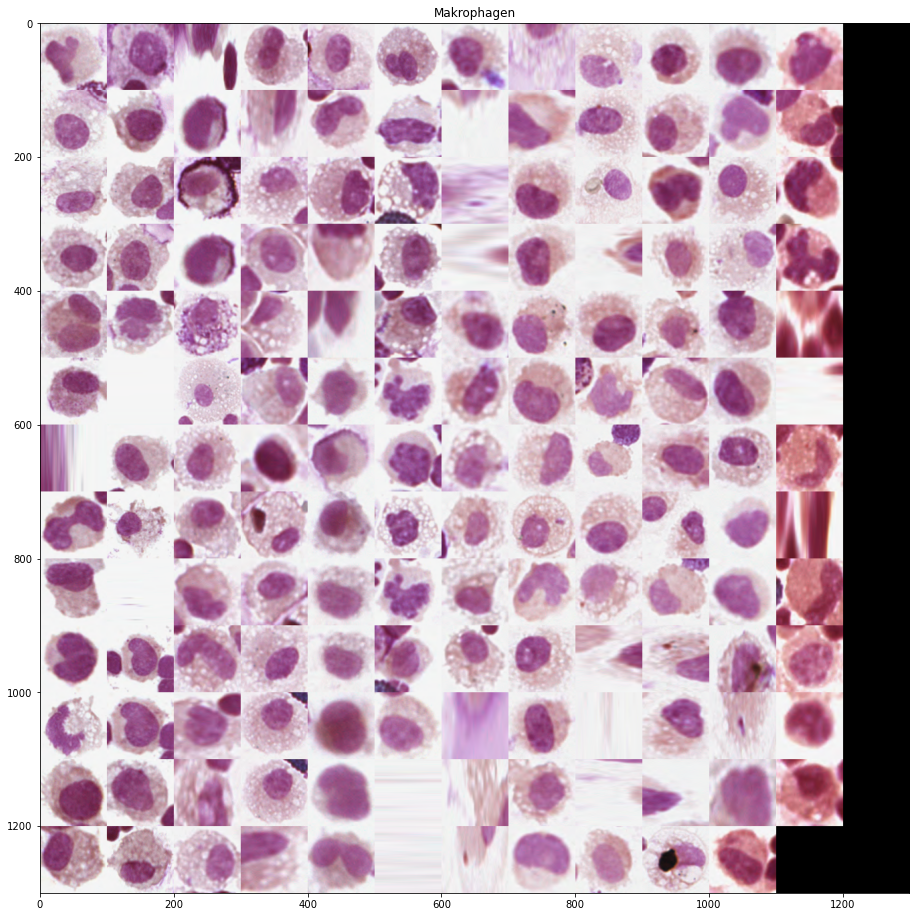

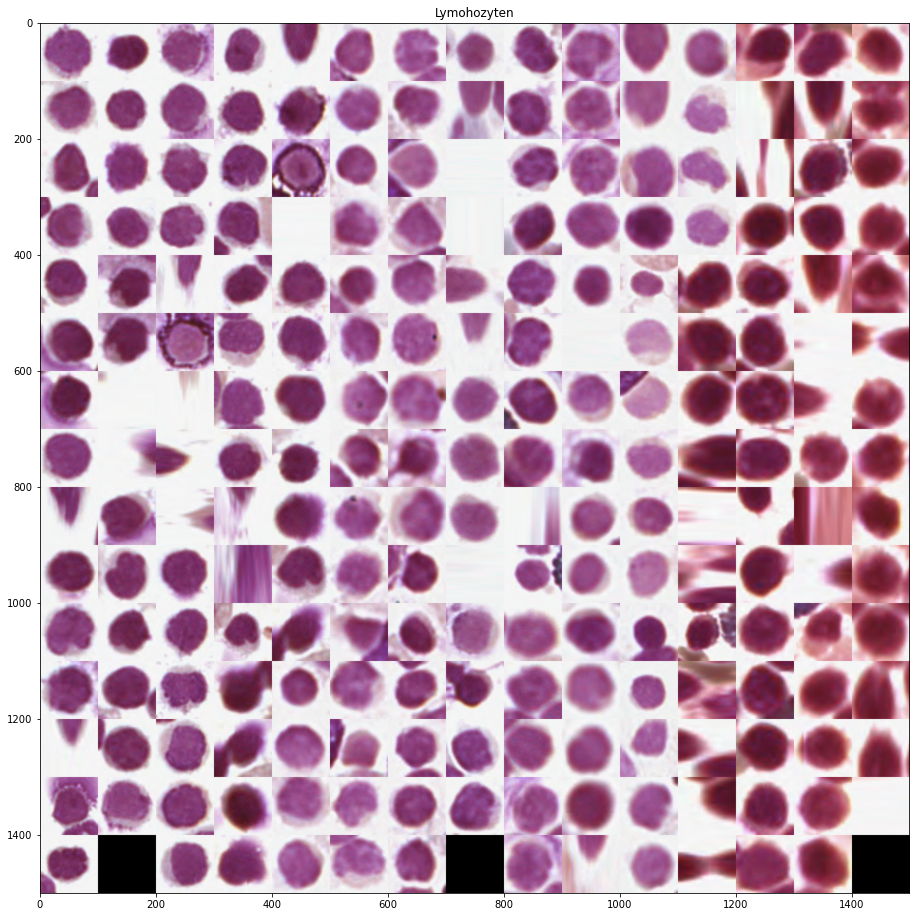

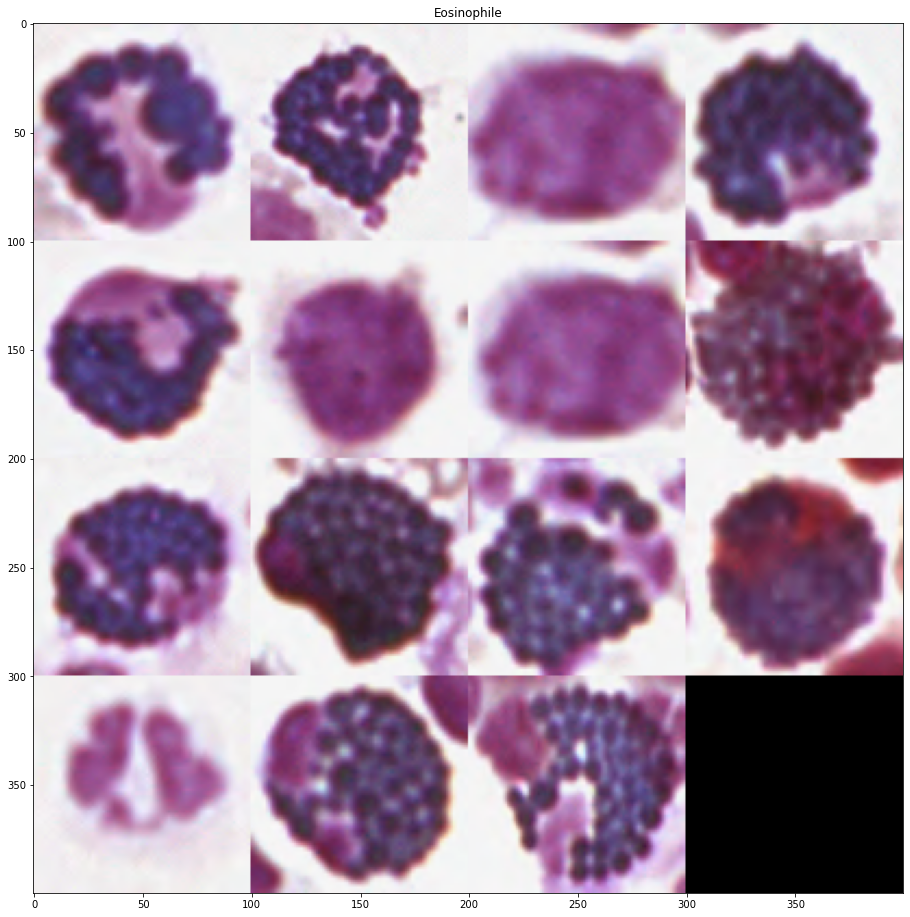

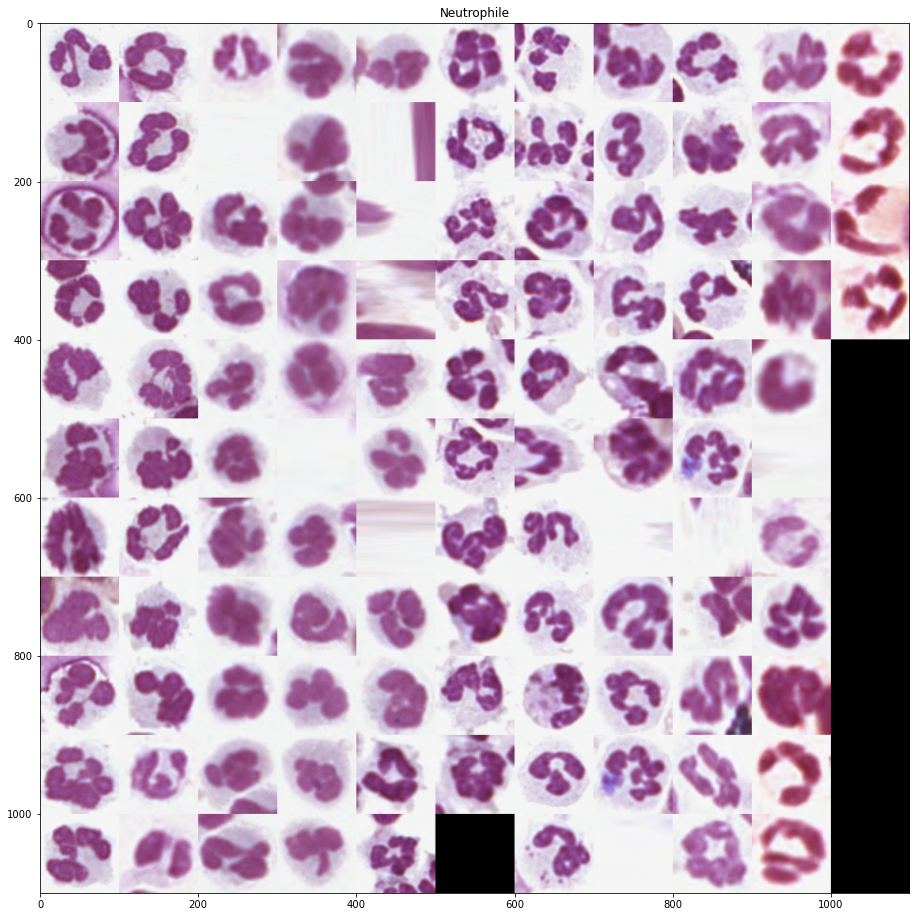

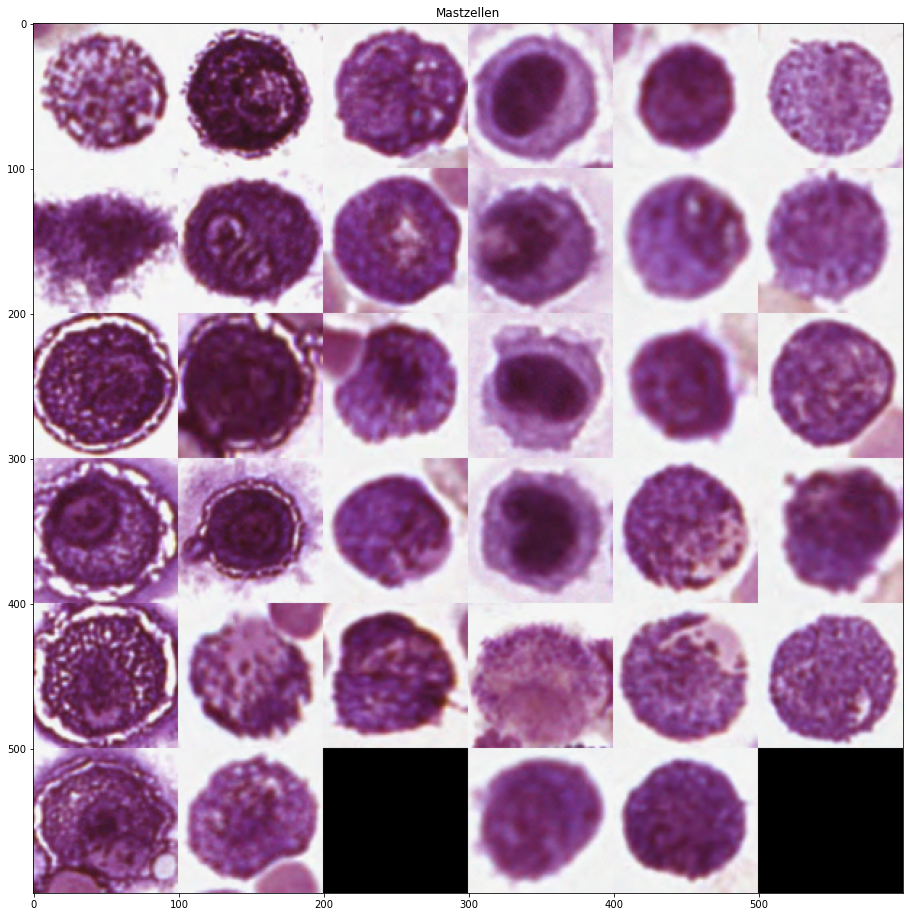

In [99]:
for name in result_image_names:
    plt.figure(figsize = (16,16))
    
    plt.title(name.split("_")[0])
    plt.imshow(cv2.imread(name))
    plt.show()